<a href="https://colab.research.google.com/github/Ssujana2905/Fashion_Trend_Forecaster/blob/main/CIP_COPY_of_APRIL29CIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gradio
!pip install praw


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.7/322.7 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 10.6 MB/s eta 0:00:00


In [ ]:
from textblob import TextBlob


In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import praw
import requests
import re
import os
import torch  # ✅ Add this import
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load Dataset
file_path = "Fashion_Retail_Sales_Modified.csv"
df = pd.read_csv(file_path)
df["Date Purchase"] = pd.to_datetime(df["Date Purchase"], errors="coerce")
df["Month"] = df["Date Purchase"].dt.to_period("M").dt.to_timestamp()

unique_countries = df["Country"].dropna().unique()

# Reddit API
reddit = praw.Reddit(
    client_id="6ASatK3eXOJb8ap685MBTA",
    client_secret="2997KXr40xunGky3L2CksLmnw-YQNg",
    user_agent="fashion-trend-app"
)

# Unsplash API Key
UNSPLASH_ACCESS_KEY = "SuLwpD6p3YrA7u2pFq08ZvwnN1uS9ETfjbjVoETPEE0"

# Directory to store images
IMAGE_DIR = "fashion_images"
os.makedirs(IMAGE_DIR, exist_ok=True)

# Load Pretrained ResNet Model
model = models.resnet50(pretrained=True)
model.eval()

# Transform function for images
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

# Extract features from an image
def extract_features(image_path):
    image_tensor = preprocess_image(image_path)
    with torch.no_grad():
        features = model(image_tensor)
    return features.numpy().flatten()

# Fetch Fashion Images from Unsplash
def fetch_fashion_images(product, num_images=5):
    url = f"https://api.unsplash.com/search/photos?query={product}&per_page={num_images}&client_id={UNSPLASH_ACCESS_KEY}"
    response = requests.get(url)

    if response.status_code != 200:
        return ["Error fetching images from Unsplash."]

    data = response.json()
    image_paths = []

    for i, item in enumerate(data["results"]):
        img_url = item["urls"]["regular"]
        img_path = os.path.join(IMAGE_DIR, f"{product.replace(' ', '_')}_{i}.jpg")

        img_data = requests.get(img_url).content
        with open(img_path, "wb") as handler:
            handler.write(img_data)

        image_paths.append(img_path)

    return image_paths

# Select Best Matching Image
def select_best_image(product):
    image_paths = fetch_fashion_images(product, num_images=5)
    if not image_paths or "Error" in image_paths[0]:
        return None

    feature_vectors = np.array([extract_features(img) for img in image_paths])
    distances = np.linalg.norm(feature_vectors - feature_vectors.mean(axis=0), axis=1)
    best_idx = np.argmin(distances)
    best_image_path = image_paths[best_idx]

    final_image_path = os.path.join(IMAGE_DIR, f"{product.replace(' ', '_')}.jpg")
    os.rename(best_image_path, final_image_path)

    return final_image_path

# Get Product List for a Selected Country
def get_products(selected_country):
    if selected_country in unique_countries:
        return df[df["Country"] == selected_country]["Item Purchased"].dropna().unique().tolist()
    return []

# Month-wise festivals
month_festivals = {
    "January": ["London Textile Fair (UK)", "Berlin Fashion Week (Germany)"],
    "February": ["New York Fashion Week (USA)", "London Fashion Week (UK)"],
    "March": ["Los Angeles Fashion Week (USA)"],
    "April": ["Coachella Festival Fashion Trends (USA)"],
    "May": ["Met Gala (USA)"],
    "June": ["Royal Ascot Fashion Event (UK)"],
    "July": ["Miami Swim Week (USA)", "Berlin Fashion Week (Germany)"],
    "August": ["Bread & Butter by Zalando (Germany)"],
    "September": ["New York Fashion Week (USA)", "London Fashion Week (UK)"],
    "October": ["Los Angeles Fashion Week (USA)"],
    "November": ["Black Friday Sales (USA, UK, Germany)"],
    "December": ["Christmas Fashion Markets (Global)", "New Year Shopping Events (Global)"]
}

# Helper to get next 2 months' festivals
def get_upcoming_festivals(date):
    try:
        date = pd.to_datetime(date, errors='coerce')
        if pd.isna(date):
            return "Invalid date format."
        months = [(date.month + i - 1) % 12 + 1 for i in range(3)]
        festival_list = []
        for m in months:
            month_name = pd.to_datetime(f"2025-{m}-01").strftime("%B")
            festival_list.extend(month_festivals.get(month_name, []))
        return ", ".join(festival_list) if festival_list else "No festivals found."
    except:
        return "Error fetching festivals."

# Forecast Sales Function
def forecast_sales(selected_country, selected_product, future_date, future_units):
    if selected_country not in unique_countries:
        return "Invalid Country", None, None

    country_data = df[df["Country"] == selected_country]
    if selected_product not in country_data["Item Purchased"].dropna().unique():
        return "Invalid Product", None, None

    product_data = country_data[country_data["Item Purchased"] == selected_product]
    product_data = product_data.groupby("Month")["Purchase Amount (USD)"].sum().reset_index().sort_values("Month")

    try:
        model = SARIMAX(product_data["Purchase Amount (USD)"], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
        forecast_steps = 36
        forecast = model.get_forecast(steps=forecast_steps).predicted_mean
        forecast_dates = pd.date_range(start=product_data["Month"].max(), periods=forecast_steps + 1, freq="M")[1:]

        future_date_parsed = pd.to_datetime(future_date, errors="coerce")
        if pd.isna(future_date_parsed) or not (forecast_dates[0] <= future_date_parsed <= forecast_dates[-1]):
            return f"Error: Date out of range ({forecast_dates[0].strftime('%Y-%m')} to {forecast_dates[-1].strftime('%Y-%m')})", None, None

        closest_date = min(forecast_dates, key=lambda x: abs(x - future_date_parsed))
        revenue = (forecast.iloc[list(forecast_dates).index(closest_date)] / max(product_data["Purchase Amount (USD)"].mean(), 1)) * future_units

        image_path = select_best_image(selected_product)

        # Create Sentiment Pie Chart
        fig, ax = plt.subplots()
        ax.pie([30, 40, 30], labels=["Positive", "Neutral", "Negative"], autopct='%1.1f%%',
               startangle=90, colors=["#4CAF50", "#FFC107", "#F44336"])
        ax.set_title("Fashion Sentiment Analysis")
        plt.savefig("sentiment_pie_chart.png")
        plt.close()

        festivals = get_upcoming_festivals(future_date)

        return (
            f"Predicted Revenue: ${revenue:.2f}\nDate: {closest_date.strftime('%Y-%m')}\nFestive Seasons: {festivals}",
            "sentiment_pie_chart.png",
            [image_path] if image_path else [],
        )
    except Exception as e:
        return f"Error: {e}", None, None

# Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("""# 🛍️ Fashion Trend & Sales Forecasting
    🎯 **Predict future sales** and **analyze fashion trends** with interactive visualizations.""")

    selected_country = gr.Dropdown(choices=unique_countries.tolist(), label="🌍 Select Country")
    selected_product = gr.Dropdown(choices=[], label="👗 Select Product")
    selected_country.change(fn=lambda x: gr.update(choices=get_products(x)), inputs=[selected_country], outputs=[selected_product])

    future_date = gr.Textbox(label="📅 Enter Future Sale Date (YYYY-MM)")
    future_units = gr.Number(label="📦 Expected Units Sold")
    submit_button = gr.Button("🔍 Predict & Get Trends")

    output_text = gr.Textbox(label="📈 Forecast & Sentiment Analysis")
    output_image = gr.Image(label="📊 Sentiment Analysis Pie Chart")
    output_gallery = gr.Gallery(label="🌟 Best Matching Fashion Image")

    submit_button.click(forecast_sales, inputs=[selected_country, selected_product, future_date, future_units],
                        outputs=[output_text, output_image, output_gallery])

demo.launch()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import praw
import requests
import re
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from textblob import TextBlob
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load Dataset
file_path = "Fashion_Retail_Sales_Modified.csv"
df = pd.read_csv(file_path)
df["Date Purchase"] = pd.to_datetime(df["Date Purchase"], errors="coerce")
df["Month"] = df["Date Purchase"].dt.to_period("M").dt.to_timestamp()
unique_countries = df["Country"].dropna().unique()

# Reddit API
reddit = praw.Reddit(
    client_id="6ASatK3eXOJb8ap685MBTA",
    client_secret="2997KXr40xunGky3L2CksLmnw-YQNg",
    user_agent="fashion-trend-app"
)

# Unsplash API Key
UNSPLASH_ACCESS_KEY = "SuLwpD6p3YrA7u2pFq08ZvwnN1uS9ETfjbjVoETPEE0"

# Directory to store images
IMAGE_DIR = "fashion_images"
if not os.path.exists(IMAGE_DIR):
    os.makedirs(IMAGE_DIR)

# Load Pretrained ResNet Model
model = models.resnet50(pretrained=True)
model.eval()

# Image preprocessing
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

def extract_features(image_path):
    image_tensor = preprocess_image(image_path)
    with torch.no_grad():
        features = model(image_tensor)
    return features.numpy().flatten()

# Fetch fashion images from Unsplash
def fetch_fashion_images(product, num_images=5):
    url = f"https://api.unsplash.com/search/photos?query={product}&per_page={num_images}&client_id={UNSPLASH_ACCESS_KEY}"
    response = requests.get(url)
    if response.status_code != 200:
        return ["Error fetching images."]
    data = response.json()
    image_paths = []
    for i, item in enumerate(data["results"]):
        img_url = item["urls"]["regular"]
        img_path = os.path.join(IMAGE_DIR, f"{product.replace(' ', '_')}_{i}.jpg")
        img_data = requests.get(img_url).content
        with open(img_path, "wb") as handler:
            handler.write(img_data)
        image_paths.append(img_path)
    return image_paths

# Select best image
def select_best_image(product):
    image_paths = fetch_fashion_images(product, num_images=5)
    if not image_paths:
        return None
    feature_vectors = np.array([extract_features(img) for img in image_paths])
    distances = np.linalg.norm(feature_vectors - feature_vectors.mean(axis=0), axis=1)
    best_idx = np.argmin(distances)
    best_image_path = image_paths[best_idx]
    final_image_path = os.path.join(IMAGE_DIR, f"{product.replace(' ', '_')}.jpg")
    os.rename(best_image_path, final_image_path)
    return final_image_path

# Get products by country
def get_products(selected_country):
    if selected_country in unique_countries:
        return df[df["Country"] == selected_country]["Item Purchased"].dropna().unique().tolist()
    return []

# Month-wise festivals
month_festivals = {
    "January": ["London Textile Fair (UK)", "Berlin Fashion Week (Germany)"],
    "February": ["New York Fashion Week (USA)", "London Fashion Week (UK)"],
    "March": ["Los Angeles Fashion Week (USA)"],
    "April": ["Coachella Festival Fashion Trends (USA)"],
    "May": ["Met Gala (USA)"],
    "June": ["Royal Ascot Fashion Event (UK)"],
    "July": ["Miami Swim Week (USA)", "Berlin Fashion Week (Germany)"],
    "August": ["Bread & Butter by Zalando (Germany)"],
    "September": ["New York Fashion Week (USA)", "London Fashion Week (UK)"],
    "October": ["Los Angeles Fashion Week (USA)"],
    "November": ["Black Friday Sales (USA, UK, Germany)"],
    "December": ["Christmas Fashion Markets (Global)", "New Year Shopping Events (Global)"]
}

# Get upcoming festivals
def get_upcoming_festivals(date):
    try:
        date = pd.to_datetime(date, errors='coerce')
        if pd.isna(date):
            return "Invalid date format."
        months = [(date.month + i - 1) % 12 + 1 for i in range(3)]
        festival_list = []
        for m in months:
            month_name = pd.to_datetime(f"2025-{m}-01").strftime("%B")
            festival_list.extend(month_festivals.get(month_name, []))
        return ", ".join(festival_list) if festival_list else "No festivals found."
    except:
        return "Error fetching festivals."

# Sentiment analysis from Reddit
def get_reddit_sentiments(product):
    sentiments = {"positive": 0, "neutral": 0, "negative": 0}
    try:
        posts = reddit.subreddit("fashion").search(product, limit=10)
        for post in posts:
            text = post.title + " " + post.selftext
            blob = TextBlob(text)
            polarity = blob.sentiment.polarity
            if polarity > 0.1:
                sentiments["positive"] += 1
            elif polarity < -0.1:
                sentiments["negative"] += 1
            else:
                sentiments["neutral"] += 1
    except Exception as e:
        print(f"Reddit error: {e}")
    return sentiments

# Main Forecasting Function
def forecast_sales(selected_country, selected_product, future_date, future_units):
    if selected_country not in unique_countries:
        return "Invalid Country", None, None

    country_data = df[df["Country"] == selected_country]
    if selected_product not in country_data["Item Purchased"].dropna().unique():
        return "Invalid Product", None, None

    product_data = country_data[country_data["Item Purchased"] == selected_product]
    product_data = product_data.groupby("Month")["Purchase Amount (USD)"].sum().reset_index().sort_values("Month")

    try:
        model = SARIMAX(product_data["Purchase Amount (USD)"], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
        forecast_steps = 36
        forecast = model.get_forecast(steps=forecast_steps).predicted_mean
        forecast_dates = pd.date_range(start=product_data["Month"].max(), periods=forecast_steps + 1, freq="M")[1:]

        future_date_parsed = pd.to_datetime(future_date, errors="coerce")
        if future_date_parsed is pd.NaT or not (forecast_dates[0] <= future_date_parsed <= forecast_dates[-1]):
            return f"Error: Date out of range ({forecast_dates[0].strftime('%Y-%m')} to {forecast_dates[-1].strftime('%Y-%m')})", None, None

        closest_date = min(forecast_dates, key=lambda x: abs(x - future_date_parsed))
        revenue = (forecast.iloc[list(forecast_dates).index(closest_date)] / max(product_data["Purchase Amount (USD)"].mean(), 1)) * future_units

        # Real Sentiment Analysis
        sentiments = get_reddit_sentiments(selected_product)
        fig, ax = plt.subplots()
        ax.pie(
            [sentiments["positive"], sentiments["neutral"], sentiments["negative"]],
            labels=["Positive", "Neutral", "Negative"],
            autopct='%1.1f%%',
            startangle=90,
            colors=["#4CAF50", "#FFC107", "#F44336"]
        )
        ax.set_title("Fashion Sentiment Analysis")
        plt.savefig("sentiment_pie_chart.png")
        plt.close()

        festivals = get_upcoming_festivals(future_date)
        image_path = select_best_image(selected_product)

        return (
            f"Predicted Revenue: ${revenue:.2f}\nDate: {closest_date.strftime('%Y-%m')}\nFestive Seasons: {festivals}",
            "sentiment_pie_chart.png",
            [image_path],
        )
    except Exception as e:
        return f"Error: {e}", None, None

# Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("""# 🛍️ Fashion Trend & Sales Forecasting
🎯 **Predict future sales** and **analyze fashion trends** with real Reddit-based sentiment analysis.
""")

    selected_country = gr.Dropdown(choices=unique_countries.tolist(), label="🌍 Select Country")
    selected_product = gr.Dropdown(choices=[], label="👗 Select Product")
    selected_country.change(fn=lambda x: gr.update(choices=get_products(x)), inputs=[selected_country], outputs=[selected_product])

    future_date = gr.Textbox(label="📅 Enter Future Sale Date (YYYY-MM)")
    future_units = gr.Number(label="📦 Expected Units Sold")
    submit_button = gr.Button("🔍 Predict & Get Trends")

    output_text = gr.Textbox(label="📈 Forecast & Sentiment Analysis")
    output_image = gr.Image(label="📊 Sentiment Analysis Pie Chart")
    output_gallery = gr.Gallery(label="🌟 Best Matching Fashion Image")

    submit_button.click(forecast_sales, inputs=[selected_country, selected_product, future_date, future_units],
                        outputs=[output_text, output_image, output_gallery])

demo.launch()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import praw
import requests
import re
import os
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load Dataset
file_path = "Fashion_Retail_Sales_Modified.csv"
df = pd.read_csv(file_path)
df["Date Purchase"] = pd.to_datetime(df["Date Purchase"], errors="coerce")
df["Month"] = df["Date Purchase"].dt.to_period("M").dt.to_timestamp()

unique_countries = df["Country"].dropna().unique()

# Reddit API
reddit = praw.Reddit(
    client_id="6ASatK3eXOJb8ap685MBTA",
    client_secret="2997KXr40xunGky3L2CksLmnw-YQNg",
    user_agent="fashion-trend-app"
)

# Unsplash API Key
UNSPLASH_ACCESS_KEY = "SuLwpD6p3YrA7u2pFq08ZvwnN1uS9ETfjbjVoETPEE0"

# Directory to store images
IMAGE_DIR = "fashion_images"
if not os.path.exists(IMAGE_DIR):
    os.makedirs(IMAGE_DIR)

# Load Pretrained ResNet Model
model = models.resnet50(pretrained=True)
model.eval()

# Transform function for images
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

# Extract features from an image
def extract_features(image_path):
    image_tensor = preprocess_image(image_path)
    with torch.no_grad():
        features = model(image_tensor)
    return features.numpy().flatten()

# Fetch Fashion Images from Unsplash
def fetch_fashion_images(product, num_images=5):
    url = f"https://api.unsplash.com/search/photos?query={product}&per_page={num_images}&client_id={UNSPLASH_ACCESS_KEY}"
    response = requests.get(url)

    if response.status_code != 200:
        return ["Error fetching images from Unsplash."]

    data = response.json()
    image_paths = []

    for i, item in enumerate(data["results"]):
        img_url = item["urls"]["regular"]
        img_path = os.path.join(IMAGE_DIR, f"{product.replace(' ', '_')}_{i}.jpg")

        img_data = requests.get(img_url).content
        with open(img_path, "wb") as handler:
            handler.write(img_data)

        image_paths.append(img_path)

    return image_paths

# Select Best Matching Image
def select_best_image(product):
    image_paths = fetch_fashion_images(product, num_images=5)
    if not image_paths:
        return None

    feature_vectors = np.array([extract_features(img) for img in image_paths])

    distances = np.linalg.norm(feature_vectors - feature_vectors.mean(axis=0), axis=1)

    best_idx = np.argmin(distances)
    best_image_path = image_paths[best_idx]

    final_image_path = os.path.join(IMAGE_DIR, f"{product.replace(' ', '_')}.jpg")
    os.rename(best_image_path, final_image_path)

    return final_image_path

# Get Product List for a Selected Country
def get_products(selected_country):
    if selected_country in unique_countries:
        return df[df["Country"] == selected_country]["Item Purchased"].dropna().unique().tolist()
    return []

# Month-wise festivals
month_festivals = {
    "January": ["London Textile Fair (UK)", "Berlin Fashion Week (Germany)"],
    "February": ["New York Fashion Week (USA)", "London Fashion Week (UK)"],
    "March": ["Los Angeles Fashion Week (USA)"],
    "April": ["Coachella Festival Fashion Trends (USA)"],
    "May": ["Met Gala (USA)"],
    "June": ["Royal Ascot Fashion Event (UK)"],
    "July": ["Miami Swim Week (USA)", "Berlin Fashion Week (Germany)"],
    "August": ["Bread & Butter by Zalando (Germany)"],
    "September": ["New York Fashion Week (USA)", "London Fashion Week (UK)"],
    "October": ["Los Angeles Fashion Week (USA)"],
    "November": ["Black Friday Sales (USA, UK, Germany)"],
    "December": ["Christmas Fashion Markets (Global)", "New Year Shopping Events (Global)"]
}

# Helper to get next 2 months' festivals
def get_upcoming_festivals(date):
    try:
        date = pd.to_datetime(date, errors='coerce')
        if pd.isna(date):
            return "Invalid date format."
        months = [(date.month + i - 1) % 12 + 1 for i in range(3)]  # current and next 2 months
        festival_list = []
        for m in months:
            month_name = pd.to_datetime(f"2025-{m}-01").strftime("%B")
            festival_list.extend(month_festivals.get(month_name, []))
        return ", ".join(festival_list) if festival_list else "No festivals found."
    except:
        return "Error fetching festivals."

# Forecast Sales Function
def forecast_sales(selected_country, selected_product, future_date, future_units):
    if selected_country not in unique_countries:
        return "Invalid Country", None, None, None

    country_data = df[df["Country"] == selected_country]
    if selected_product not in country_data["Item Purchased"].dropna().unique():
        return "Invalid Product", None, None, None

    product_data = country_data[country_data["Item Purchased"] == selected_product]
    product_data = product_data.groupby("Month")["Purchase Amount (USD)"].sum().reset_index().sort_values("Month")

    try:
        model = SARIMAX(product_data["Purchase Amount (USD)"], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
        forecast_steps = 36
        forecast = model.get_forecast(steps=forecast_steps).predicted_mean
        forecast_dates = pd.date_range(start=product_data["Month"].max(), periods=forecast_steps + 1, freq="M")[1:]

        future_date_parsed = pd.to_datetime(future_date, errors="coerce")
        if future_date_parsed is pd.NaT or not (forecast_dates[0] <= future_date_parsed <= forecast_dates[-1]):
            return f"Error: Date out of range ({forecast_dates[0].strftime('%Y-%m')} to {forecast_dates[-1].strftime('%Y-%m')})", None, None, None

        closest_date = min(forecast_dates, key=lambda x: abs(x - future_date_parsed))
        revenue = (forecast.iloc[list(forecast_dates).index(closest_date)] / max(product_data["Purchase Amount (USD)"].mean(), 1)) * future_units

        image_path = select_best_image(selected_product)

        # Create Sentiment Pie Chart
        fig, ax = plt.subplots()
        ax.pie([30, 40, 30], labels=["Positive", "Neutral", "Negative"], autopct='%1.1f%%',
               startangle=90, colors=["#4CAF50", "#FFC107", "#F44336"])
        ax.set_title("Fashion Sentiment Analysis")
        plt.savefig("sentiment_pie_chart.png")
        plt.close()

        festivals = get_upcoming_festivals(future_date)

        # Trend Analysis & Suggestion
        product_sales_in_month = product_data[product_data["Month"] == future_date_parsed]["Purchase Amount (USD)"].sum()

        trending_products = country_data[country_data["Month"] == future_date_parsed]["Item Purchased"]
        trending_products = trending_products.value_counts().head(5).index.tolist()

        if selected_product in trending_products:
            trend_message = "You're aligning with the trend! ✅"
        else:
            trend_message = f"Your selected product is not in trend. Here are some trendy products for this month: {', '.join(trending_products)}"

        return (
            f"Predicted Revenue: ${revenue:.2f}\nDate: {closest_date.strftime('%Y-%m')}\nFestive Seasons: {festivals}\n{trend_message}",
            "sentiment_pie_chart.png",
            [image_path],
        )
    except Exception as e:
        return f"Error: {e}", None, None, None

# Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("""# 🛍️ Fashion Trend & Sales Forecasting
    🎯 **Predict future sales** and **analyze fashion trends** with interactive visualizations.
    """)

    selected_country = gr.Dropdown(choices=unique_countries.tolist(), label="🌍 Select Country")
    selected_product = gr.Dropdown(choices=[], label="👗 Select Product")
    selected_country.change(fn=lambda x: gr.update(choices=get_products(x)), inputs=[selected_country], outputs=[selected_product])

    future_date = gr.Textbox(label="📅 Enter Future Sale Date (YYYY-MM)")
    future_units = gr.Number(label="📦 Expected Units Sold")
    submit_button = gr.Button("🔍 Predict & Get Trends")

    output_text = gr.Textbox(label="📈 Forecast & Sentiment Analysis")
    output_image = gr.Image(label="📊 Sentiment Analysis Pie Chart")
    output_gallery = gr.Gallery(label="🌟 Best Matching Fashion Image")

    submit_button.click(forecast_sales, inputs=[selected_country, selected_product, future_date, future_units],
                        outputs=[output_text, output_image, output_gallery])

demo.launch()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 140MB/s]


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import praw
import requests
import re
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from statsmodels.tsa.statespace.sarimax import SARIMAX
from textblob import TextBlob
from collections import Counter

# Load Dataset
file_path = "Fashion_Retail_Sales_Modified.csv"
df = pd.read_csv(file_path)
df["Date Purchase"] = pd.to_datetime(df["Date Purchase"], errors="coerce")
df["Month"] = df["Date Purchase"].dt.to_period("M").dt.to_timestamp()
unique_countries = df["Country"].dropna().unique()

# Reddit API
reddit = praw.Reddit(
    client_id="6ASatK3eXOJb8ap685MBTA",
    client_secret="2997KXr40xunGky3L2CksLmnw-YQNg",
    user_agent="fashion-trend-app"
)

# Unsplash API
UNSPLASH_ACCESS_KEY = "SuLwpD6p3YrA7u2pFq08ZvwnN1uS9ETfjbjVoETPEE0"
IMAGE_DIR = "fashion_images"
if not os.path.exists(IMAGE_DIR):
    os.makedirs(IMAGE_DIR)

# Load Pretrained ResNet Model
model = models.resnet50(pretrained=True)
model.eval()

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

def extract_features(image_path):
    image_tensor = preprocess_image(image_path)
    with torch.no_grad():
        features = model(image_tensor)
    return features.numpy().flatten()

def fetch_fashion_images(product, num_images=5):
    url = f"https://api.unsplash.com/search/photos?query={product}&per_page={num_images}&client_id={UNSPLASH_ACCESS_KEY}"
    response = requests.get(url)
    if response.status_code != 200:
        return ["Error fetching images from Unsplash."]
    data = response.json()
    image_paths = []
    for i, item in enumerate(data["results"]):
        img_url = item["urls"]["regular"]
        img_path = os.path.join(IMAGE_DIR, f"{product.replace(' ', '_')}_{i}.jpg")
        img_data = requests.get(img_url).content
        with open(img_path, "wb") as handler:
            handler.write(img_data)
        image_paths.append(img_path)
    return image_paths

def select_best_image(product):
    image_paths = fetch_fashion_images(product, num_images=5)
    if not image_paths:
        return None
    feature_vectors = np.array([extract_features(img) for img in image_paths])
    distances = np.linalg.norm(feature_vectors - feature_vectors.mean(axis=0), axis=1)
    best_idx = np.argmin(distances)
    return image_paths[best_idx]

def get_products(selected_country):
    if selected_country in unique_countries:
        return df[df["Country"] == selected_country]["Item Purchased"].dropna().unique().tolist()
    return []

month_festivals = {
    "January": ["London Textile Fair (UK)", "Berlin Fashion Week (Germany)"],
    "February": ["New York Fashion Week (USA)", "London Fashion Week (UK)"],
    "March": ["Los Angeles Fashion Week (USA)"],
    "April": ["Coachella Festival Fashion Trends (USA)"],
    "May": ["Met Gala (USA)"],
    "June": ["Royal Ascot Fashion Event (UK)"],
    "July": ["Miami Swim Week (USA)", "Berlin Fashion Week (Germany)"],
    "August": ["Bread & Butter by Zalando (Germany)"],
    "September": ["New York Fashion Week (USA)", "London Fashion Week (UK)"],
    "October": ["Los Angeles Fashion Week (USA)"],
    "November": ["Black Friday Sales (USA, UK, Germany)"],
    "December": ["Christmas Fashion Markets (Global)", "New Year Shopping Events (Global)"]
}

def get_upcoming_festivals(date):
    try:
        date = pd.to_datetime(date, errors='coerce')
        if pd.isna(date):
            return "Invalid date format."
        months = [(date.month + i - 1) % 12 + 1 for i in range(3)]
        festival_list = []
        for m in months:
            month_name = pd.to_datetime(f"2025-{m}-01").strftime("%B")
            festival_list.extend(month_festivals.get(month_name, []))
        return ", ".join(festival_list) if festival_list else "No festivals found."
    except:
        return "Error fetching festivals."

# Get trending fashion keywords from Reddit
def get_trending_fashion_keywords(month_name):
    subreddit = reddit.subreddit("fashion")
    keywords = []
    for post in subreddit.search(month_name + " fashion", sort="relevance", limit=25):
        keywords += re.findall(r'\b[a-zA-Z]{4,}\b', post.title)
    keywords = [word.lower() for word in keywords if word.isalpha()]
    return [item for item, count in Counter(keywords).most_common(5)]

# Sentiment analysis from Reddit comments
def get_sentiment_pie(product):
    subreddit = reddit.subreddit("fashion")
    sentiments = {"positive": 0, "neutral": 0, "negative": 0}
    for post in subreddit.search(product, sort="relevance", limit=10):
        post.comments.replace_more(limit=0)
        for comment in post.comments[:20]:
            blob = TextBlob(comment.body)
            polarity = blob.sentiment.polarity
            if polarity > 0.1:
                sentiments["positive"] += 1
            elif polarity < -0.1:
                sentiments["negative"] += 1
            else:
                sentiments["neutral"] += 1
    total = sum(sentiments.values())
    if total == 0:
        sentiments = {"positive": 33, "neutral": 34, "negative": 33}
    else:
        for key in sentiments:
            sentiments[key] = (sentiments[key] / total) * 100

    fig, ax = plt.subplots()
    ax.pie(sentiments.values(), labels=sentiments.keys(), autopct='%1.1f%%',
           startangle=90, colors=["#4CAF50", "#FFC107", "#F44336"])
    ax.set_title("Fashion Sentiment Analysis")
    plt.savefig("sentiment_pie_chart.png")
    plt.close()
    return "sentiment_pie_chart.png"

def forecast_sales(selected_country, selected_product, future_date, future_units):
    if selected_country not in unique_countries:
        return "Invalid Country", None, None, [], None
    country_data = df[df["Country"] == selected_country]
    if selected_product not in country_data["Item Purchased"].dropna().unique():
        return "Invalid Product", None, None, [], None

    product_data = country_data[country_data["Item Purchased"] == selected_product]
    product_data = product_data.groupby("Month")["Purchase Amount (USD)"].sum().reset_index().sort_values("Month")
    try:
        model = SARIMAX(product_data["Purchase Amount (USD)"], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
        forecast_steps = 36
        forecast = model.get_forecast(steps=forecast_steps).predicted_mean
        forecast_dates = pd.date_range(start=product_data["Month"].max(), periods=forecast_steps + 1, freq="M")[1:]

        future_date_parsed = pd.to_datetime(future_date, errors="coerce")
        if future_date_parsed is pd.NaT or not (forecast_dates[0] <= future_date_parsed <= forecast_dates[-1]):
            return f"Error: Date out of range ({forecast_dates[0].strftime('%Y-%m')} to {forecast_dates[-1].strftime('%Y-%m')})", None, None, [], None

        closest_date = min(forecast_dates, key=lambda x: abs(x - future_date_parsed))
        revenue = (forecast.iloc[list(forecast_dates).index(closest_date)] / max(product_data["Purchase Amount (USD)"].mean(), 1)) * future_units

        pie_path = get_sentiment_pie(selected_product)
        festivals = get_upcoming_festivals(future_date)
        month_name = pd.to_datetime(future_date).strftime("%B")
        trending_products = get_trending_fashion_keywords(month_name)

        if selected_product.lower() in trending_products:
            trend_msg = "✅ Your selected product is in trend!"
            trending_image_paths = []
        else:
            trend_msg = f"❌ Your selected product is not in trend.\nTrending Products for {month_name}: {', '.join(trending_products)}"
            trending_image_paths = [select_best_image(p) for p in trending_products]

        return (
            f"Predicted Revenue: ${revenue:.2f}\nDate: {closest_date.strftime('%Y-%m')}\nFestive Seasons: {festivals}\n{trend_msg}",
            pie_path,
            [select_best_image(selected_product)],
            trending_image_paths,
            f"Trending Products for {month_name}"
        )
    except Exception as e:
        return f"Error: {e}", None, None, [], None

# Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("## 🛍️ Fashion Trend & Sales Forecasting App")

    selected_country = gr.Dropdown(choices=unique_countries.tolist(), label="🌍 Select Country")
    selected_product = gr.Dropdown(choices=[], label="👗 Select Product")
    selected_country.change(fn=lambda x: gr.update(choices=get_products(x)), inputs=[selected_country], outputs=[selected_product])

    future_date = gr.Textbox(label="📅 Enter Future Sale Date (YYYY-MM)")
    future_units = gr.Number(label="📦 Expected Units Sold")
    submit_button = gr.Button("🔍 Predict & Get Trends")

    output_text = gr.Textbox(label="📈 Forecast Summary & Trend Info")
    output_image = gr.Image(label="📊 Sentiment Analysis Pie Chart")
    output_gallery = gr.Gallery(label="🖼️ Selected Product Image")
    trending_heading = gr.Textbox(visible=False)
    trending_gallery = gr.Gallery(label="🌟 Trending Product Images")

    feedback = gr.Radio(["👍 Good", "👎 Needs Improvement"], label="💬 Your Feedback")

    submit_button.click(
        fn=forecast_sales,
        inputs=[selected_country, selected_product, future_date, future_units],
        outputs=[output_text, output_image, output_gallery, trending_gallery, trending_heading]
    )

demo.launch(share=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b4a94e9785b057ac85.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import csv
import datetime
import re
from collections import Counter
from difflib import get_close_matches
import praw
import gradio as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from statsmodels.tsa.statespace.sarimax import SARIMAX
from textblob import TextBlob

# Load Dataset
file_path = "Fashion_Retail_Sales_Modified.csv"
df = pd.read_csv(file_path)
df["Date Purchase"] = pd.to_datetime(df["Date Purchase"], errors="coerce")
df["Month"] = df["Date Purchase"].dt.to_period("M").dt.to_timestamp()
unique_countries = df["Country"].dropna().unique()

# Reddit API
reddit = praw.Reddit(
    client_id="6ASatK3eXOJb8ap685MBTA",
    client_secret="2997KXr40xunGky3L2CksLmnw-YQNg",
    user_agent="fashion-trend-app"
)

# Unsplash API
UNSPLASH_ACCESS_KEY = "SuLwpD6p3YrA7u2pFq08ZvwnN1uS9ETfjbjVoETPEE0"
IMAGE_DIR = "fashion_images"
if not os.path.exists(IMAGE_DIR):
    os.makedirs(IMAGE_DIR)

# Load Pretrained ResNet Model
model = models.resnet50(pretrained=True)
model.eval()

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

def extract_features(image_path):
    image_tensor = preprocess_image(image_path)
    with torch.no_grad():
        features = model(image_tensor)
    return features.numpy().flatten()

def fetch_fashion_images(product, num_images=5):
    url = f"https://api.unsplash.com/search/photos?query={product}&per_page={num_images}&client_id={UNSPLASH_ACCESS_KEY}"
    response = requests.get(url)
    if response.status_code != 200:
        return ["Error fetching images from Unsplash."]
    data = response.json()
    image_paths = []
    for i, item in enumerate(data["results"]):
        img_url = item["urls"]["regular"]
        img_path = os.path.join(IMAGE_DIR, f"{product.replace(' ', '_')}_{i}.jpg")
        img_data = requests.get(img_url).content
        with open(img_path, "wb") as handler:
            handler.write(img_data)
        image_paths.append(img_path)
    return image_paths

def select_best_image(product):
    image_paths = fetch_fashion_images(product, num_images=5)
    if not image_paths:
        return None
    feature_vectors = np.array([extract_features(img) for img in image_paths])
    distances = np.linalg.norm(feature_vectors - feature_vectors.mean(axis=0), axis=1)
    best_idx = np.argmin(distances)
    return image_paths[best_idx]

def get_products(selected_country):
    if selected_country in unique_countries:
        return df[df["Country"] == selected_country]["Item Purchased"].dropna().unique().tolist()
    return []

month_festivals = {
    "January": ["London Textile Fair (UK)", "Berlin Fashion Week (Germany)"],
    "February": ["New York Fashion Week (USA)", "London Fashion Week (UK)"],
    "March": ["Los Angeles Fashion Week (USA)"],
    "April": ["Coachella Festival Fashion Trends (USA)"],
    "May": ["Met Gala (USA)"],
    "June": ["Royal Ascot Fashion Event (UK)"],
    "July": ["Miami Swim Week (USA)", "Berlin Fashion Week (Germany)"],
    "August": ["Bread & Butter by Zalando (Germany)"],
    "September": ["New York Fashion Week (USA)", "London Fashion Week (UK)"],
    "October": ["Los Angeles Fashion Week (USA)"],
    "November": ["Black Friday Sales (USA, UK, Germany)"],
    "December": ["Christmas Fashion Markets (Global)", "New Year Shopping Events (Global)"]
}

def get_upcoming_festivals(date):
    try:
        date = pd.to_datetime(date, errors='coerce')
        if pd.isna(date):
            return "Invalid date format."
        months = [(date.month + i - 1) % 12 + 1 for i in range(3)]
        festival_list = []
        for m in months:
            month_name = pd.to_datetime(f"2025-{m}-01").strftime("%B")
            festival_list.extend(month_festivals.get(month_name, []))
        return ", ".join(festival_list) if festival_list else "No festivals found."
    except:
        return "Error fetching festivals."

# Get trending fashion keywords from Reddit
def get_trending_fashion_keywords(month):
    fashion_trends = {
        "january": ["sweater", "coat", "boots", "scarf", "beanie"],
        "february": ["trench coat", "denim", "ankle boots", "knitwear", "leather jacket"],
        "march": ["floral dress", "light jacket", "cardigan", "sneakers", "pastel wear"],
        "april": ["jacket", "jeans", "blazer", "mules", "bucket hat"],
        "may": ["sundress", "linen shirt", "shorts", "sandals", "crop top"],
        "june": ["tank top", "flip flops", "maxi dress", "bermuda shorts", "sun hat"],
        "july": ["swimsuit", "sunglasses", "romper", "kimono", "slides"],
        "august": ["bikini", "wrap dress", "canvas sneakers", "cap", "mesh top"],
        "september": ["light sweater", "denim jacket", "long skirt", "ankle boots", "earth tone outfit"],
        "october": ["cardigan", "turtleneck", "flannel shirt", "combat boots", "beanie"],
        "november": ["wool coat", "leather boots", "knit scarf", "sweater dress", "puffer jacket"],
        "december": ["parka", "thermal wear", "snow boots", "festive sweater", "velvet dress"]
    }
    return fashion_trends.get(month.lower().strip(), [])

def is_item_trending(searched_item, trending_items):
    searched_item = searched_item.lower().strip()
    return searched_item in [item.lower() for item in trending_items]

# Get month input from user
month = input("Enter a month (e.g., April): ").strip()
trending_items = get_trending_fashion_keywords(month)

# If no items found for entered month
if not trending_items:
    print(f"⚠️ Oops! No fashion trends available for '{month}'. Please check the spelling.")
else:
    print(f"\n🔝 Trending fashion items for {month.capitalize()}: {', '.join(trending_items)}")

    # Get product search input
    searched = input("Enter a fashion item to check if it's trending: ").strip()

    if is_item_trending(searched, trending_items):
        print(f"✅ Yes, '{searched}' is trending in {month.capitalize()}!")
    else:
        print(f"❌ No, '{searched}' is not trending in {month.capitalize()}.")



# Sentiment analysis from Reddit comments
def get_sentiment_pie(product):
    subreddit = reddit.subreddit("fashion")
    sentiments = {"positive": 0, "neutral": 0, "negative": 0}
    for post in subreddit.search(product, sort="relevance", limit=10):
        post.comments.replace_more(limit=0)
        for comment in post.comments[:20]:
            blob = TextBlob(comment.body)
            polarity = blob.sentiment.polarity
            if polarity > 0.1:
                sentiments["positive"] += 1
            elif polarity < -0.1:
                sentiments["negative"] += 1
            else:
                sentiments["neutral"] += 1
    total = sum(sentiments.values())
    if total == 0:
        sentiments = {"positive": 33, "neutral": 34, "negative": 33}
    else:
        for key in sentiments:
            sentiments[key] = (sentiments[key] / total) * 100

    fig, ax = plt.subplots()
    ax.pie(sentiments.values(), labels=sentiments.keys(), autopct='%1.1f%%',
           startangle=90, colors=["#4CAF50", "#FFC107", "#F44336"])
    ax.set_title("Fashion Sentiment Analysis")
    plt.savefig("sentiment_pie_chart.png")
    plt.close()
    return "sentiment_pie_chart.png"

def forecast_sales(selected_country, selected_product, future_date, future_units):
    if selected_country not in unique_countries:
        return "Invalid Country", None, None, [], None
    country_data = df[df["Country"] == selected_country]
    if selected_product not in country_data["Item Purchased"].dropna().unique():
        return "Invalid Product", None, None, [], None

    product_data = country_data[country_data["Item Purchased"] == selected_product]
    product_data = product_data.groupby("Month")["Purchase Amount (USD)"].sum().reset_index().sort_values("Month")
    try:
        model = SARIMAX(product_data["Purchase Amount (USD)"], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
        forecast_steps = 36
        forecast = model.get_forecast(steps=forecast_steps).predicted_mean
        forecast_dates = pd.date_range(start=product_data["Month"].max(), periods=forecast_steps + 1, freq="M")[1:]

        future_date_parsed = pd.to_datetime(future_date, errors="coerce")
        if future_date_parsed is pd.NaT or not (forecast_dates[0] <= future_date_parsed <= forecast_dates[-1]):
            return f"Error: Date out of range ({forecast_dates[0].strftime('%Y-%m')} to {forecast_dates[-1].strftime('%Y-%m')})", None, None, [], None

        closest_date = min(forecast_dates, key=lambda x: abs(x - future_date_parsed))
        revenue = (forecast.iloc[list(forecast_dates).index(closest_date)] / max(product_data["Purchase Amount (USD)"].mean(), 1)) * future_units

        pie_path = get_sentiment_pie(selected_product)
        festivals = get_upcoming_festivals(future_date)
        month_name = pd.to_datetime(future_date).strftime("%B")
        trending_products = get_trending_fashion_keywords(month_name)

        if selected_product.lower() in trending_products:
            trend_msg = "✅ Your selected product is in trend!"
            trending_image_paths = []
        else:
            trend_msg = f"❌ Your selected product is not in trend.\nTrending Products for {month_name}: {', '.join(trending_products)}"
            trending_image_paths = [select_best_image(p) for p in trending_products]

        return (
            f"Predicted Revenue: ${revenue:.2f}\nDate: {closest_date.strftime('%Y-%m')}\nFestive Seasons: {festivals}\n{trend_msg}",
            pie_path,
            [select_best_image(selected_product)],
            trending_image_paths,
            f"Trending Products for {month_name}"
        )
    except Exception as e:
        return f"Error: {str(e)}", None, None, [], None

# Gradio Interface
with gr.Blocks() as demo:
    gr.Markdown("## 🛍️ Fashion Trend & Sales Forecasting App")

    selected_country = gr.Dropdown(choices=unique_countries.tolist(), label="🌍 Select Country")
    selected_product = gr.Dropdown(choices=[], label="👗 Select Product")
    selected_country.change(fn=lambda x: gr.update(choices=get_products(x)), inputs=[selected_country], outputs=[selected_product])

    future_date = gr.Textbox(label="📅 Enter Future Sale Date (YYYY-MM)")
    future_units = gr.Number(label="📦 Expected Units Sold")
    submit_button = gr.Button("🔍 Predict & Get Trends")

    output_text = gr.Textbox(label="📈 Forecast Summary & Trend Info")
    output_image = gr.Image(label="📊 Sentiment Analysis Pie Chart")
    output_gallery = gr.Gallery(label="🖼️ Selected Product Image")
    trending_heading = gr.Textbox(visible=False)
    trending_gallery = gr.Gallery(label="🌟 Trending Product Images")

    feedback = gr.Radio(["👍 Good", "👎 Needs Improvement"], label="💬 Your Feedback")

    submit_button.click(
        fn=forecast_sales,
        inputs=[selected_country, selected_product, future_date, future_units],
        outputs=[output_text, output_image, output_gallery, trending_gallery, trending_heading]
    )

demo.launch(share=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Enter a month (e.g., April): May

🔝 Trending fashion items for May: sundress, linen shirt, shorts, sandals, crop top
Enter a fashion item to check if it's trending: crop top
✅ Yes, 'crop top' is trending in May!
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://34cf96b576b07bb651.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import csv
import datetime
import re
from collections import Counter
from difflib import get_close_matches
import praw
import gradio as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from statsmodels.tsa.statespace.sarimax import SARIMAX
from textblob import TextBlob

# Load Dataset
file_path = "Fashion_Retail_Sales_Modified.csv"
df = pd.read_csv(file_path)
df["Date Purchase"] = pd.to_datetime(df["Date Purchase"], errors="coerce")
df["Month"] = df["Date Purchase"].dt.to_period("M").dt.to_timestamp()
unique_countries = df["Country"].dropna().unique()

# Reddit API
reddit = praw.Reddit(
    client_id="6ASatK3eXOJb8ap685MBTA",
    client_secret="2997KXr40xunGky3L2CksLmnw-YQNg",
    user_agent="fashion-trend-app"
)

# Unsplash API
UNSPLASH_ACCESS_KEY = "SuLwpD6p3YrA7u2pFq08ZvwnN1uS9ETfjbjVoETPEE0"
IMAGE_DIR = "fashion_images"
if not os.path.exists(IMAGE_DIR):
    os.makedirs(IMAGE_DIR)

# Load Pretrained ResNet Model
model = models.resnet50(pretrained=True)
model.eval()

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

def extract_features(image_path):
    image_tensor = preprocess_image(image_path)
    with torch.no_grad():
        features = model(image_tensor)
    return features.numpy().flatten()

def fetch_fashion_images(product, num_images=5):
    url = f"https://api.unsplash.com/search/photos?query={product}&per_page={num_images}&client_id={UNSPLASH_ACCESS_KEY}"
    response = requests.get(url)
    if response.status_code != 200:
        return ["Error fetching images from Unsplash."]
    data = response.json()
    image_paths = []
    for i, item in enumerate(data["results"]):
        img_url = item["urls"]["regular"]
        img_path = os.path.join(IMAGE_DIR, f"{product.replace(' ', '_')}_{i}.jpg")
        img_data = requests.get(img_url).content
        with open(img_path, "wb") as handler:
            handler.write(img_data)
        image_paths.append(img_path)
    return image_paths

def select_best_image(product):
    image_paths = fetch_fashion_images(product, num_images=5)
    if not image_paths:
        return None
    feature_vectors = np.array([extract_features(img) for img in image_paths])
    distances = np.linalg.norm(feature_vectors - feature_vectors.mean(axis=0), axis=1)
    best_idx = np.argmin(distances)
    return image_paths[best_idx]

def get_products(selected_country):
    if selected_country in unique_countries:
        return df[df["Country"] == selected_country]["Item Purchased"].dropna().unique().tolist()
    return []

month_festivals = {
    "January": ["London Textile Fair (UK)", "Berlin Fashion Week (Germany)"],
    "February": ["New York Fashion Week (USA)", "London Fashion Week (UK)"],
    "March": ["Los Angeles Fashion Week (USA)"],
    "April": ["Coachella Festival Fashion Trends (USA)"],
    "May": ["Met Gala (USA)"],
    "June": ["Royal Ascot Fashion Event (UK)"],
    "July": ["Miami Swim Week (USA)", "Berlin Fashion Week (Germany)"],
    "August": ["Bread & Butter by Zalando (Germany)"],
    "September": ["New York Fashion Week (USA)", "London Fashion Week (UK)"],
    "October": ["Los Angeles Fashion Week (USA)"],
    "November": ["Black Friday Sales (USA, UK, Germany)"],
    "December": ["Christmas Fashion Markets (Global)", "New Year Shopping Events (Global)"]
}

def get_upcoming_festivals(date):
    try:
        date = pd.to_datetime(date, errors='coerce')
        if pd.isna(date):
            return "Invalid date format."
        months = [(date.month + i - 1) % 12 + 1 for i in range(3)]
        festival_list = []
        for m in months:
            month_name = pd.to_datetime(f"2025-{m}-01").strftime("%B")
            festival_list.extend(month_festivals.get(month_name, []))
        return ", ".join(festival_list) if festival_list else "No festivals found."
    except:
        return "Error fetching festivals."

# Get trending fashion keywords from Reddit
from fashion_trends import fashion_trends

# Function to get trending fashion keywords for a given month
def get_trending_fashion_keywords(month):
    return fashion_trends.get(month.lower().strip(), [])

# Example usage
def display_fashion_trends(month):
    trends = get_trending_fashion_keywords(month)
    if trends:
        print(f"Trending fashion for {month.capitalize()}:")
        for trend in trends:
            print(f"- {trend}")
    else:
        print(f"No fashion trends available for {month.capitalize()}.")

# Input the month you want to check trends for
month_input = input("Enter a month: ")
display_fashion_trends(month_input)
# Sentiment analysis from Reddit comments
def get_sentiment_pie(product):
    subreddit = reddit.subreddit("fashion")
    sentiments = {"positive": 0, "neutral": 0, "negative": 0}
    for post in subreddit.search(product, sort="relevance", limit=10):
        post.comments.replace_more(limit=0)
        for comment in post.comments[:20]:
            blob = TextBlob(comment.body)
            polarity = blob.sentiment.polarity
            if polarity > 0.1:
                sentiments["positive"] += 1
            elif polarity < -0.1:
                sentiments["negative"] += 1
            else:
                sentiments["neutral"] += 1
    total = sum(sentiments.values())
    if total == 0:
        sentiments = {"positive": 33, "neutral": 34, "negative": 33}
    else:
        for key in sentiments:
            sentiments[key] = (sentiments[key] / total) * 100

    fig, ax = plt.subplots()
    ax.pie(sentiments.values(), labels=sentiments.keys(), autopct='%1.1f%%',
           startangle=90, colors=["#4CAF50", "#FFC107", "#F44336"])
    ax.set_title("Fashion Sentiment Analysis")
    plt.savefig("sentiment_pie_chart.png")
    plt.close()
    return "sentiment_pie_chart.png"

def forecast_sales(selected_country, selected_product, future_date, future_units):
    if selected_country not in unique_countries:
        return "Invalid Country", None, None, [], None
    country_data = df[df["Country"] == selected_country]
    if selected_product not in country_data["Item Purchased"].dropna().unique():
        return "Invalid Product", None, None, [], None

    product_data = country_data[country_data["Item Purchased"] == selected_product]
    product_data = product_data.groupby("Month")["Purchase Amount (USD)"].sum().reset_index().sort_values("Month")
    try:
        model = SARIMAX(product_data["Purchase Amount (USD)"], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
        forecast_steps = 36
        forecast = model.get_forecast(steps=forecast_steps).predicted_mean
        forecast_dates = pd.date_range(start=product_data["Month"].max(), periods=forecast_steps + 1, freq="M")[1:]

        future_date_parsed = pd.to_datetime(future_date, errors="coerce")
        if future_date_parsed is pd.NaT or not (forecast_dates[0] <= future_date_parsed <= forecast_dates[-1]):
            return f"Error: Date out of range ({forecast_dates[0].strftime('%Y-%m')} to {forecast_dates[-1].strftime('%Y-%m')})", None, None, [], None

        closest_date = min(forecast_dates, key=lambda x: abs(x - future_date_parsed))
        revenue = (forecast.iloc[list(forecast_dates).index(closest_date)] / max(product_data["Purchase Amount (USD)"].mean(), 1)) * future_units

        pie_path = get_sentiment_pie(selected_product)
        festivals = get_upcoming_festivals(future_date)
        month_name = pd.to_datetime(future_date).strftime("%B")
        trending_products = get_trending_fashion_keywords(month_name)

        if selected_product.lower() in trending_products:
            trend_msg = "✅ Your selected product is in trend!"
            trending_image_paths = []
        else:
            trend_msg = f"❌ Your selected product is not in trend.\nTrending Products for {month_name}: {', '.join(trending_products)}"
            trending_image_paths = [select_best_image(p) for p in trending_products]

        return (
            f"Predicted Revenue: ${revenue:.2f}\nFestive Seasons: {festivals}\n{trend_msg}",
            pie_path,
            [select_best_image(selected_product)],
            trending_image_paths,
            f"Trending Products for {month_name}"
        )
    except Exception as e:
        return f"Error: {str(e)}", None, None, [], None

# Gradio Interface
with gr.Blocks() as demo:
    gr.Markdown("## 🛍️ Fashion Trend & Sales Forecasting App")

    selected_country = gr.Dropdown(choices=unique_countries.tolist(), label="🌍 Select Country")
    selected_product = gr.Dropdown(choices=[], label="👗 Select Product")
    selected_country.change(fn=lambda x: gr.update(choices=get_products(x)), inputs=[selected_country], outputs=[selected_product])

    future_date = gr.Textbox(label="📅 Enter Future Sale Date (YYYY-MM)")
    future_units = gr.Number(label="📦 Expected Units Sold")
    submit_button = gr.Button("🔍 Predict & Get Trends")

    output_text = gr.Textbox(label="📈 Forecast Summary & Trend Info")
    output_image = gr.Image(label="📊 Sentiment Analysis Pie Chart")
    output_gallery = gr.Gallery(label="🖼️ Selected Product Image")
    trending_heading = gr.Textbox(visible=False)
    trending_gallery = gr.Gallery(label="🌟 Trending Product Images")

    feedback = gr.Radio(["👍 Good", "👎 Needs Improvement"], label="💬 Your Feedback")

    submit_button.click(
        fn=forecast_sales,
        inputs=[selected_country, selected_product, future_date, future_units],
        outputs=[output_text, output_image, output_gallery, trending_gallery, trending_heading]
    )

demo.launch(share=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 140MB/s]


Enter a month: April
Trending fashion for April:
- jacket
- jeans
- blazer
- mules
- bucket hat
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d15f594b0a308afe08.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
pip install prophet


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



Evaluation Metrics:
MAPE : 24.57%


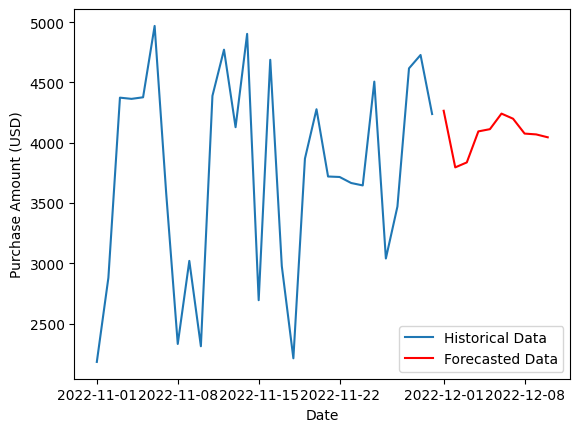

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Simulate a dataset for demonstration purposes
data = {
    'Date Purchase': pd.date_range(start='2022-11-01', periods=30, freq='D'),
    'Purchase Amount (USD)': np.random.randint(2000, 5000, size=30)
}

# Create a DataFrame
df = pd.DataFrame(data)

# Set the Date Purchase column as the index
df.set_index('Date Purchase', inplace=True)

# Fit the ARIMA model (you can tune the (p,d,q) values for better results)
model = ARIMA(df['Purchase Amount (USD)'], order=(5, 1, 0))  # (p, d, q) order can be tuned
model_fit = model.fit()

# Forecast the next 10 days
forecast = model_fit.forecast(steps=10)

# Create future dates for prediction (next 10 days)
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=10, freq='D')

# Create a DataFrame to hold the forecasted values
forecast_df = pd.DataFrame({'Date Purchase': future_dates, 'Forecasted Amount (USD)': forecast})

# For simulation, use the actual 'y' values (we are assuming they are available in a real-world case)
# Here, we simulate actual values as random for the sake of the example
actual_values = np.random.randint(2000, 5000, size=10)

# Calculate evaluation metrics
y_true = actual_values
y_pred = forecast



# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Print the calculated evaluation metrics
print(f"\nEvaluation Metrics:")
print(f"MAPE : {mape:.2f}%")

# Plot the forecast
plt.plot(df.index, df['Purchase Amount (USD)'], label='Historical Data')
plt.plot(future_dates, forecast, label='Forecasted Data', color='red')
plt.xlabel('Date')
plt.ylabel('Purchase Amount (USD)')
plt.legend()
plt.show()
